# Exploratory Data Analysing Using Youtube Video Data from Most Popular Formula1 Channels

# 1.Aims and objectives

## 1.1 Introduction
Founded in 2005, Youtube has grown to become the second largest search engine in the world (behind Google) that processes more than 3 billion searches per month. It is, however, generally a myth how the Youtube algorithm works, what makes a video get views and be recommended over another. In fact, YouTube has one of the largest scale and most sophisticated industrial recommendation systems in existence. For new content creators, it is a challenge to understand why a video gets video and others do not. There are many "myths" around the success of a Youtube video, for example if the video has more likes or comments, or if the video is of a certain duration. It is also worth experimenting and looking for "trends" in the topics that Youtube channels are covering in a certain niche.

Being a follower of the sport since 2014, I decided to gain some insights into the most popular formula1 content creators on youtube. The scope of this small project is limited to formula1 channels and I will not consider other niches (that might have a different characteristics and audience base). Therefore, in this project will explore the statistics of around 5most successful formula Youtube channel.

## 1.2. Aims and Objectives
Within this project i would like to explore the following:
* Getting to know youtube API and obtaining video data
* Analyzing video data and verifying different myths as to what makes a video perform well on youtube space, for example:
    * Does the ratio of likes and comments matter?
    * Does the duration of the video matter?
    * Does the length of the title matter?
    * How many tags do good performing video have and what are the common tags?
    * How often do they upload the video?
* Explore trending topics using NLP techniques
    * Which popular trend is being covered in the video?
    * Which questions are being asked in the comment section?

## 1.3 Steps and Process
1. Obtain video meta data via Youtube API for 5 channels in the data formula one niche (this includes several small steps: create a developer key, request data and transform the responses into a usable data format)
2. Prepocess data and engineer additional features for analysis
3. Exploratory data analysis
4. Conclusions

In [2]:
#importing libraries

from dateutil import parser
import pandas as pd
from IPython.display import JSON
import isodate

#Data Visualisation packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

#Google API
from googleapiclient.discovery import build

In [3]:
#NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2. Data Creation using Youtube API
I first created a project on Google Developers Console, then requested an authorization credential (API key). Afterwards, I enabled Youtube API for my application, so that I can send API requests to Youtube API services. Then, I went on Youtube and checked the channel ID of each of the channels that I would like to include in my research scope (using their URLs). Then I created the functions for getting the channel statistics via the API.

In [4]:
with open('api.txt', 'r') as file:
    api_key = file.read().strip()

channel_ids = ["UCtbLA0YM6EpwUQhFUyPQU9Q",#Driver 61 Channel
               "UCDxm-FbK9nmZKqHI19j-DOw",#WTF1 Channel
               "UCFHaLSX-Kqy5pGTszklkE8w",#Tommo's F1 channel
               "UCo6MV9Xd5pHfLMsLGNWnYTA",#Formula World Channel
               "UCaTxfj0BzL-MaCy-YUqPRoQ",#The Race Channel
              ]

In [5]:
# Get credentials and create an API client
youtube = build("youtube", "v3", developerKey=api_key)

In [6]:
"""
Get channel stats

Params:
------
youtube: build object of Youtube API
channel_ids: list of channel IDs

Returns:
------
dataframe with all channel stats for each channel ID

"""
def get_channel_stats(youtube, channel_ids):
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=",".join(channel_ids))
    response = request.execute()

    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)


def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """ 
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part = "snippet,contentDetails",
        playlistId = playlist_id,
        maxResults = 50)
    response = request.execute()
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    return pd.DataFrame(all_video_info)


def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments) 

### Get Channel Statistics
Using the `get_channel_stats` function defined above we are going to obtain the channel statistics for all the channels

In [7]:
channel_data = get_channel_stats(youtube, channel_ids)

Now we can view the channel statistics for the above mentioned channels

In [8]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,Formula World,232000,94267681,696,UUo6MV9Xd5pHfLMsLGNWnYTA
1,WTF1,1140000,289329906,795,UUDxm-FbK9nmZKqHI19j-DOw
2,Driver61,963000,149014245,227,UUtbLA0YM6EpwUQhFUyPQU9Q
3,THE RACE,917000,274582425,1705,UUaTxfj0BzL-MaCy-YUqPRoQ
4,Tommo,280000,32375030,222,UUFHaLSX-Kqy5pGTszklkE8w


In [9]:
channel_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   channelName  5 non-null      object
 1   subscribers  5 non-null      object
 2   views        5 non-null      object
 3   totalVideos  5 non-null      object
 4   playlistId   5 non-null      object
dtypes: object(5)
memory usage: 328.0+ bytes


I noticed the *'Subscribers', 'Views' and 'Total Videos'* columns in `channel_data` is currently in string format, so I will convert them into numeric so that we can visualize and do numeric operations on them.

In [10]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

Let's take a look at the number of subscribers per channel to have a view of how popular the channels are when compared with one another.

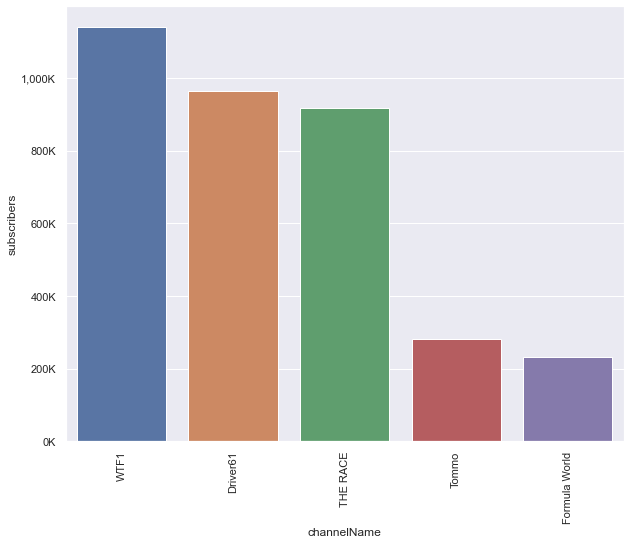

In [11]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Next, we will look at the rank considering the total number of views of the channels. WTF1 remains the most popular channel, however *The Race* has fairly more views compared to *Driver61* despite having less subscribers and a similar trend can be seen between *Formula world* and *Tommo* channels.

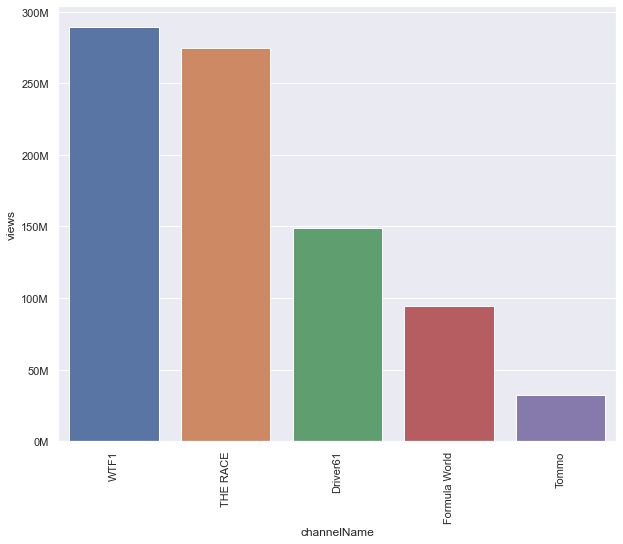

In [12]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

### Get video statistics of all channels
In the next step, we will obtain the video statistics for all the channels. In total, we obtained 3,642 videos as seen in below.

In [13]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = pd.concat([video_df,video_data])
    comments_df = pd.concat([comments_df,comments_data])

Getting video information from channel: Formula World
Getting video information from channel: WTF1
Getting video information from channel: Driver61
Could not get comments for video uyYWrfaofyw
Getting video information from channel: THE RACE
Getting video information from channel: Tommo
Could not get comments for video MzpUubJPD0w


In [14]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,V97VC5K7CPk,Formula World,Hamilton Suggests Everyone Racing In “The Same...,One question that many often wonder about is r...,None,2022-09-04T07:33:18Z,26143,992,None,1161,PT2M43S,hd,false
1,vBBg7mgQN9I,Formula World,"Oscar Piastri Reveals ""Bizarre"" And ""Upsetting...",The dust is slowly starting to settle after al...,None,2022-09-03T16:12:18Z,55531,1834,None,246,PT3M45S,hd,false
2,w1Gh5wNtsBQ,Formula World,Why Hamilton Won’t Talk To Alonso Despite Want...,The 2022 Belgian GP was an action-packed race ...,None,2022-08-30T17:31:34Z,41782,1471,None,737,PT3M18S,hd,false
3,ll-9K9LBUVs,Formula World,Why Audi Believe They Will Be Competitive Stra...,"After months of speculation, Audi confirmed th...",None,2022-08-29T10:36:47Z,26984,1038,None,126,PT2M49S,hd,false
4,Jko2FXPuJYQ,Formula World,Lando Norris Brutally Honest Has “No Sympathy”...,One of the key reasons given for Daniel Riccia...,None,2022-08-28T19:52:06Z,149855,3080,None,732,PT3M13S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,cV8PMaR7uUA,Tommo,RICH ENERGY vs RED BULL : The Taste Test,Rich Energy claims to have the superior produc...,"[RICH ENERGY, HAAS F1, RED BULL, RED BULL RACI...",2019-09-03T18:01:15Z,148601,5615,None,253,PT6M55S,hd,false
219,Ep33aw1VCXw,Tommo,F1 2021 is HERE!,https://www.formula1.com/en/latest/article.fir...,"[F1 2021, 2021 car, Wind tunnel, New regulatio...",2019-08-23T12:55:05Z,7910,380,None,10,PT2M25S,hd,false
220,r5QH6qzX3Pk,Tommo,ROKiT - Who are they??,ROKiT announced themselves to the world at the...,"[ROKiT, Williams F1, F1 Sponsors, Rich Energy,...",2019-08-20T16:00:09Z,110831,3551,None,208,PT7M19S,hd,false
221,UP6YWG3W17o,Tommo,ALBON REPLACES GASLY AT RED BULL,Alexander Albon has just been announced as Red...,"[Alex Albon, Pierre Gasly, Red Bull, Red Bull ...",2019-08-12T14:38:28Z,10563,501,None,24,PT4M38S,hd,false


In [15]:
comments_df

,video_id,comments
0,V97VC5K7CPk,[*Link to poll:* https://www.youtube.com/post/...
1,vBBg7mgQN9I,[*Link to poll:* https://www.youtube.com/post/...
2,w1Gh5wNtsBQ,[*Link to poll:* https://www.youtube.com/post/...
3,ll-9K9LBUVs,[Link to poll: https://www.youtube.com/post/Ug...
4,Jko2FXPuJYQ,[*Link to poll:* https://www.youtube.com/post/...
...,...,...
217,cV8PMaR7uUA,[Water down Red Bull and seeing Josh Revell vi...
218,Ep33aw1VCXw,"[F, Hey, It’s me from 2021, there is going to ..."
219,r5QH6qzX3Pk,[ROKiT also sponsors Ronnie “The Rocket” O’Sul...
220,UP6YWG3W17o,[Honestly they should've signed Kimi as 2nd dr...


In [16]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top5_channels.csv')
comments_df.to_csv('comments_data_top5_channels.csv')

### Processing and Feature Engineering
To be able to make use of the data for analysis, we need to perform a few pre-processing steps. Firstly, I would like reformat some columns, especially the date and time columns such as "pushlishedAt" and "duration". In addition, I also think it is necessary to enrich the data with some new features that might be useful for understanding the videos' characteristics.

#### Checking for empty values

In [17]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount          True
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [18]:
video_df.publishedAt.sort_values().value_counts()

2013-03-21T13:30:30Z    5
2013-10-01T07:59:18Z    3
2013-07-10T10:36:51Z    2
2014-05-23T13:13:31Z    2
2013-09-05T20:57:39Z    2
                       ..
2019-09-09T16:35:54Z    1
2019-09-09T17:20:26Z    1
2019-09-09T21:05:21Z    1
2019-09-10T17:17:03Z    1
2022-09-04T20:24:37Z    1
Name: publishedAt, Length: 3633, dtype: int64

Next, we need to check if the data type of the columns are correct. I have checked the data types and indeed some count columns such as view count and comment count are currently not in correct data type. In this step, we convert these count columns into integer.

In [19]:
cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

#### Enriching data
I want to enrich the data for further analyses, for example:

* create published date column with another column showing the day in the week the video was published, which will be useful for later analysis.

* convert video duration to seconds instead of the current default string format

* calculate number of tags for each video

* calculate comments and likes per 1000 view ratio

* calculate title character length

In [20]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [21]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [22]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [23]:
# Comments and likes per 1000 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 1000
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 1000

In [24]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

Let's look at the video dataset at this point to see if everything went well. It looks good - now we will proceed to exploratory analysis part.

In [25]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,durationSecs,tagsCount,likeRatio,commentRatio,titleLength
0,V97VC5K7CPk,Formula World,Hamilton Suggests Everyone Racing In “The Same...,One question that many often wonder about is r...,None,2022-09-04 07:33:18+00:00,26143.0,992.0,NaN,1161.0,PT2M43S,hd,false,Sunday,163.0,0,37.945148,44.409593,80
1,vBBg7mgQN9I,Formula World,"Oscar Piastri Reveals ""Bizarre"" And ""Upsetting...",The dust is slowly starting to settle after al...,None,2022-09-03 16:12:18+00:00,55531.0,1834.0,NaN,246.0,PT3M45S,hd,false,Saturday,225.0,0,33.026598,4.429958,73
2,w1Gh5wNtsBQ,Formula World,Why Hamilton Won’t Talk To Alonso Despite Want...,The 2022 Belgian GP was an action-packed race ...,None,2022-08-30 17:31:34+00:00,41782.0,1471.0,NaN,737.0,PT3M18S,hd,false,Tuesday,198.0,0,35.206548,17.639175,61
3,ll-9K9LBUVs,Formula World,Why Audi Believe They Will Be Competitive Stra...,"After months of speculation, Audi confirmed th...",None,2022-08-29 10:36:47+00:00,26984.0,1038.0,NaN,126.0,PT2M49S,hd,false,Monday,169.0,0,38.467240,4.669434,55
4,Jko2FXPuJYQ,Formula World,Lando Norris Brutally Honest Has “No Sympathy”...,One of the key reasons given for Daniel Riccia...,None,2022-08-28 19:52:06+00:00,149855.0,3080.0,NaN,732.0,PT3M13S,hd,false,Sunday,193.0,0,20.553201,4.884722,60


## Exploratory analysis

#### View Distribution per channel
With the video statistics for all channel, now we can see how the views are distributed per channel. Some channels might have a lot of views on one of their videos and the rest do not receive many views. Other channels might have more evenly distribution views per video.

C:\Users\robin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


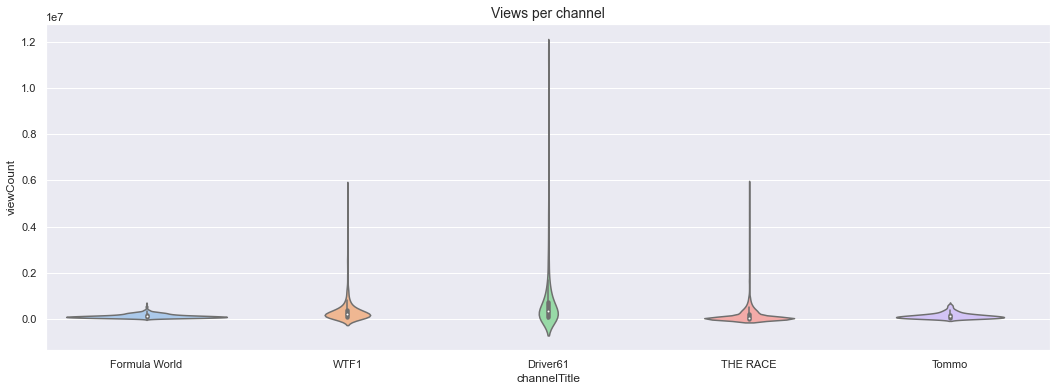

In [26]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plt.show()

#### Does the number of likes and comments matter for a video to get more views?
Firstly, I would like to check if comments and likes do correlate with how many views a video would get. In the plots below, it can be observed that the number of views and number of comments/ likes are correlated with each other. The number of likes seems to suggest stronger correlation than the number of comments. However, this is expected as the more people watching a video, the more likely this video will get comments and likes. 

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

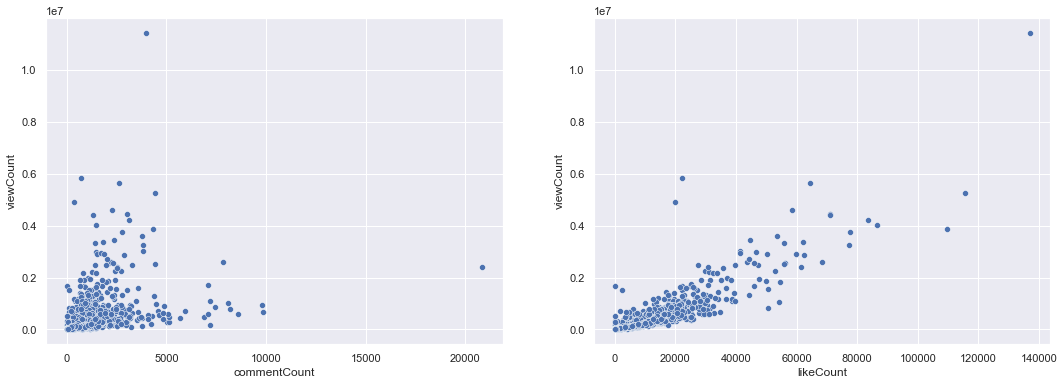

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

Now we will take a look at the correlation if we look at the comment ratio and like ratio instead of the absolute number.

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

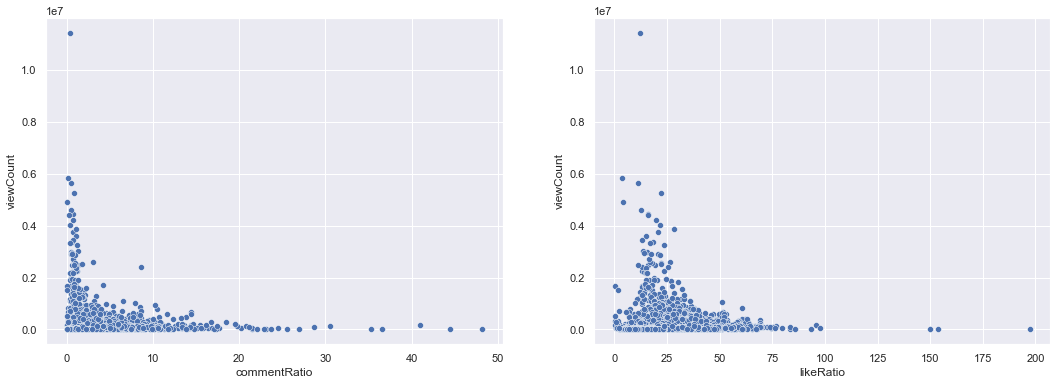

In [28]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

After correcting for the absolute number of views, it turns out that the correlation is much less clear. The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some videos have very few views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

As for like-view relatioship, we can still see some positive correlation between views and like ratio (though very subtle), which means that the more views a video has, the more people would hit the like button! This seems to support the idea of social proof, which means that people tend to like better the products that are already liked by many other people.

#### Does the duration of the video affect it's performance
The plot below indicates that a duration below `2000` seconds generates more views compared to heigher duration videos.

<AxesSubplot:xlabel='durationSecs', ylabel='viewCount'>

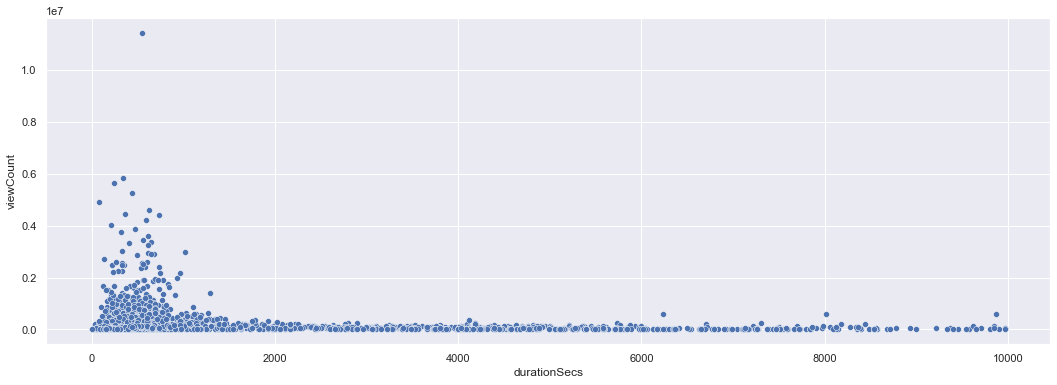

In [48]:
sns.scatterplot(data=video_df[video_df['durationSecs'] < 10000], x = "durationSecs", y = "viewCount")

the plot below shows that the optimal duration for getting likes and comments is `5000` seconds, videos in this duration range tend to perform better compared to other videos.

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

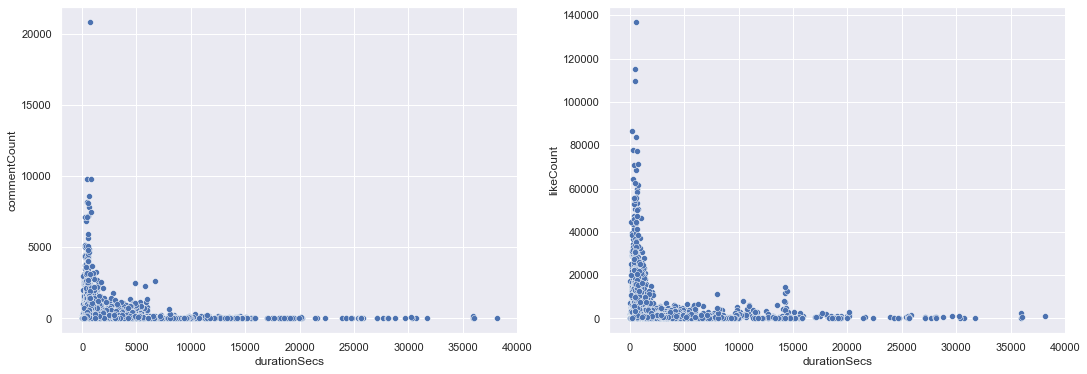

In [32]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

#### Does title length matter for views?
There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 30-60 characters.

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

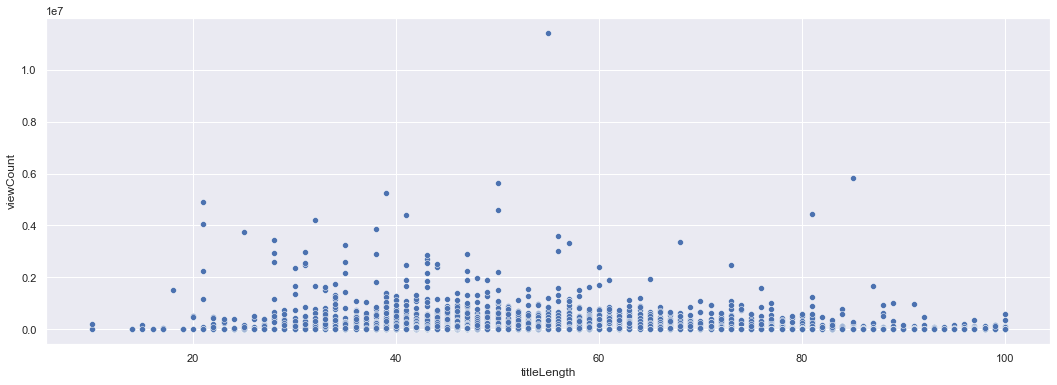

In [33]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")

#### Wordcloud for words in title
As I'm interested to see what the creators are making videos about and which terms most frequently appear in their video titles, I will create a wordcloud for the most common words.

In [34]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

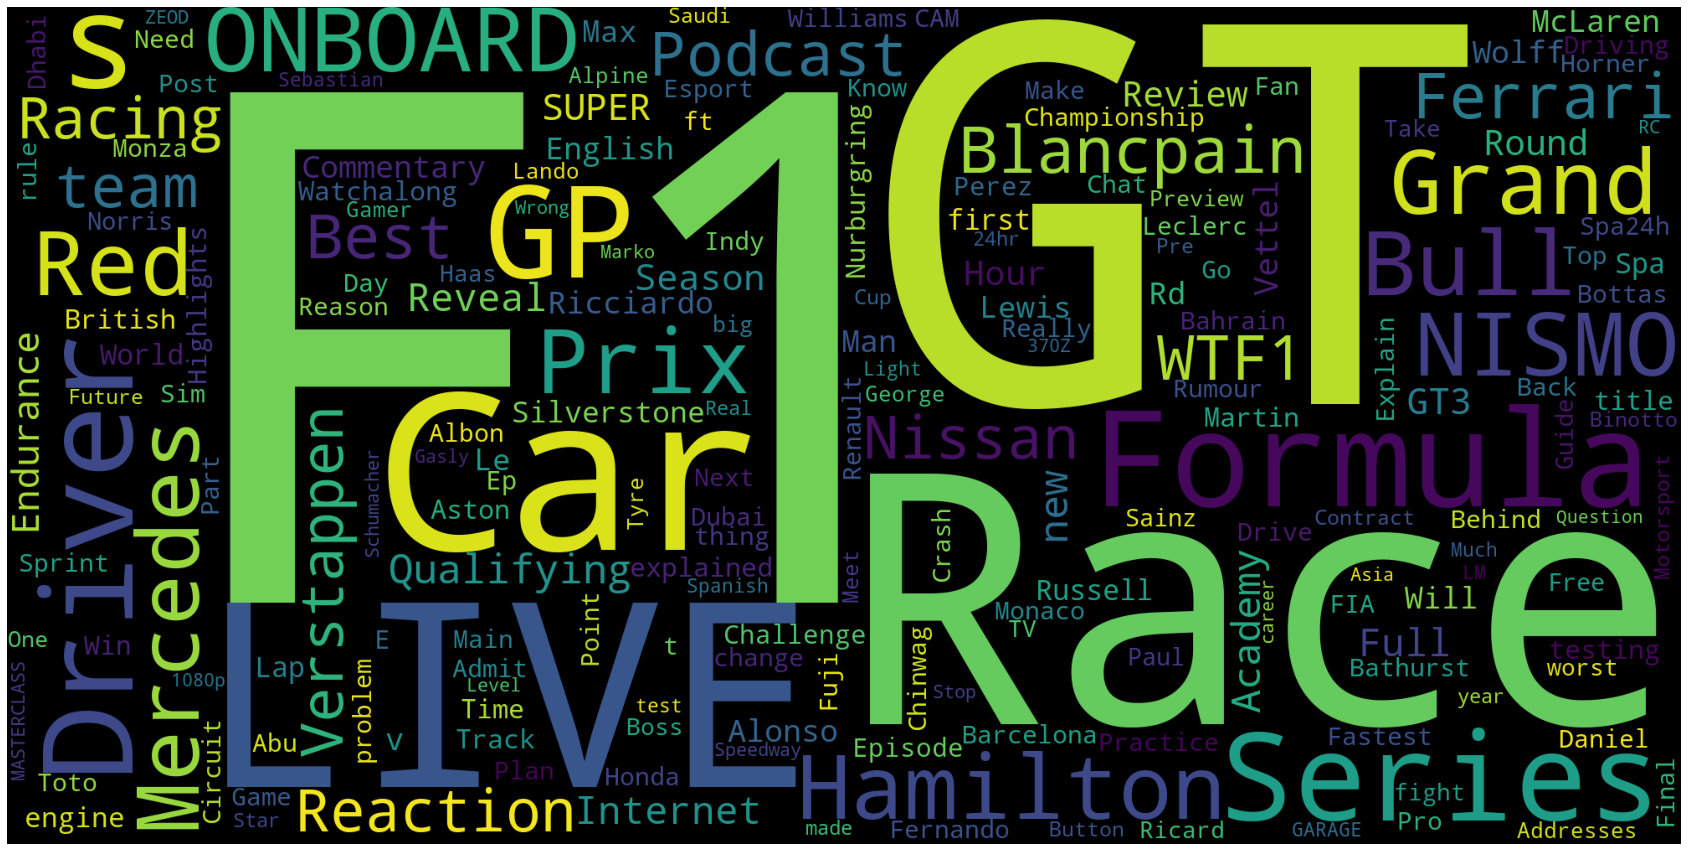

In [35]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

It can be seen that most common words are F1, Car, Team Name, GP Race, Driver Name which is very expected.

#### Number of tags vs views
It seems that most videos have between 15 and 35 tags. The relationship between number of tags and view count is not clearly seen, but too few tags or too many tags do seem to correlate with fewer views.

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

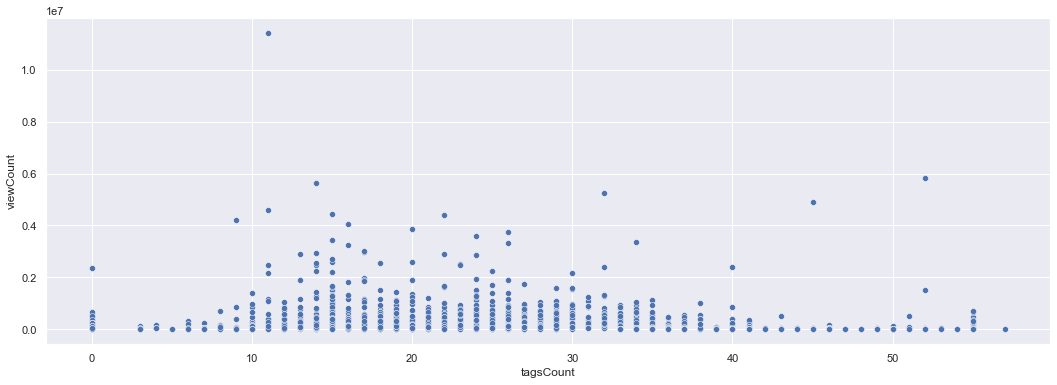

In [36]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

#### Which day in the week are most videos uploaded?
It's interesting to see that more videos are uploaded on Mondays, Thursdays and Fridays. Fewer videos are uploaded during the weekend. This could be because of the nature of the sport which runs on weekends and the viewers are engaged during the race weeks. A preview of the race is uploaded on Thursday and Friday as the race weekend begins that day and on Monday an analysis for the race is uploaded.

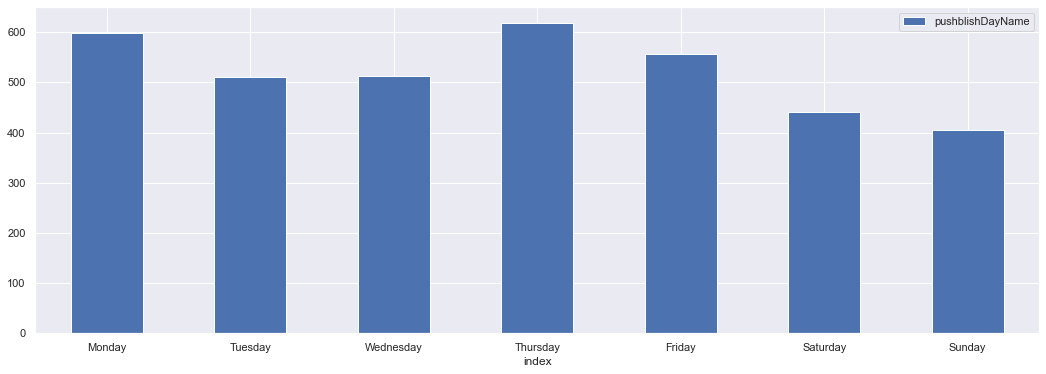

In [49]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

#### Wordcloud for video comments
We can see what are the frequently-mentioned words in the video comments. I will do this by visualizing the keywords in a wordcloud.

In [40]:
stop_words = set(stopwords.words('english'))
comments_df['comments_no_stopwords'] = comments_df['comments'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in comments_df['comments_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

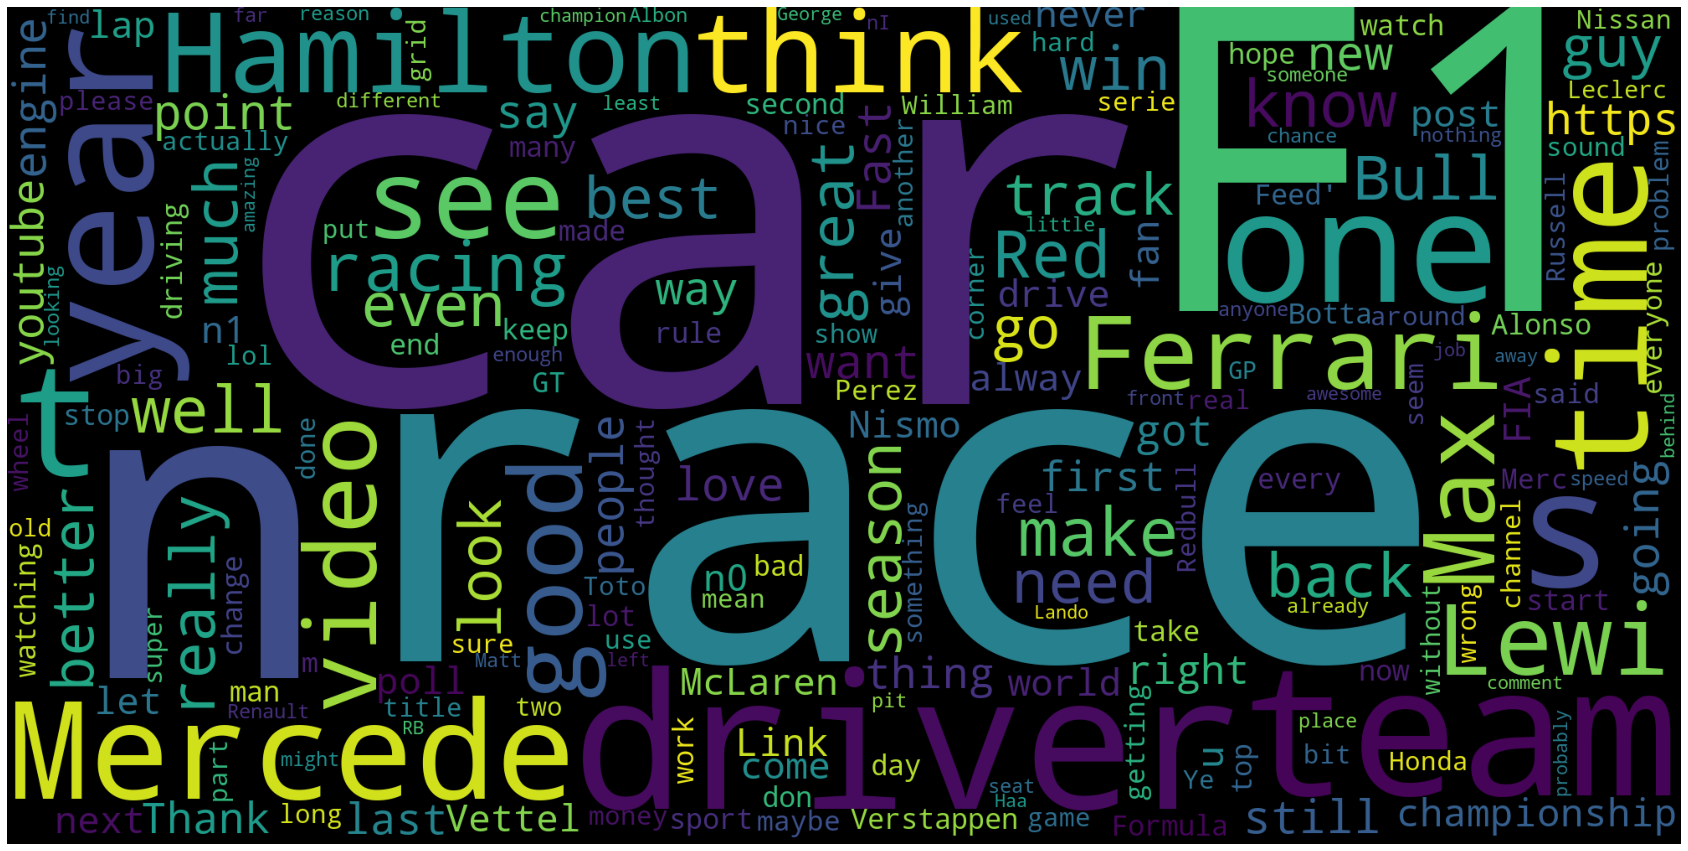

In [39]:
wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

We can see that the most common used words in the comment section are related to the sport such as Car, F1, Video, Driver, Track, Time, Driver and Team names.

### Conclusion
In this project, we have explored the video data of the 5 most popular Formula 1 insights channels and revealed many interesting findings for anyone who are starting out with a Youtube channel in Formula one domain.

* The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.

* Most videos have between 15 and 35 tags.

* Most-viewed videos tend to have average title length of 30-60 characters. Too short or too long titles seem to harm viewership.

* Videos are usually uploaded on Mondays, Thursdays and Fridays. Weekends and Sunday in particular is not a popular time for posting new videos.

* Comments on videos are generally sport related, we noticed a lot Driver Name, Team Names that means viewers are interested in teams and drivers related content.

### Project limitation:

The findings should also be taken with a grain of salt for a number of reasons:

The number of videos is quite small (the dataset has only ~3,600 videos).

I have only considered the first 10 comments on each video, which might not be representative for all comments.

There are many other factors that haven't been taken into the analysis, including the marketing strategy of the creators and many random effects that would affect how successful a video is.

### Ideas for future research:

To expand and build on this research project, one can:

Expand the dataset to also smaller channels in Formula1 niche

Do sentiment analysis on the comments and find out which videos get more positive comments and which videos get less positive comments

Do market research by analyzing questions in the comment threads and identifying common questions/ market gaps which could potentially filled

Conduct this research for other niches (e.g. Technical analysis, upgrades), to compare different niches with each other to see the different patterns in viewership and video characteristics.

### References/ Resources used:
[1] Youtube API. Avaiable at https://developers.google.com/youtube/v3

[2] Converting video durations to time function. https://stackoverflow.com/questions/15596753/how-do-i-get-video-durations-with-youtube-api-version-3